# Potato Disease Classification

### Import all the Dependencies

In [69]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

### Set all the Constants

In [70]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 8
IMAGE_SIZE_l = 555
IMAGE_SIZE_h = 500
default_image_size = tuple((IMAGE_SIZE_l, IMAGE_SIZE_h))
image_size = 0
data_dir = "../../db"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [71]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [72]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 999 files belonging to 3 classes.


### Checking the Available Classes

In [73]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Level_0', 'Level_1', 'Level_2']


### Displaying Some Sample Images

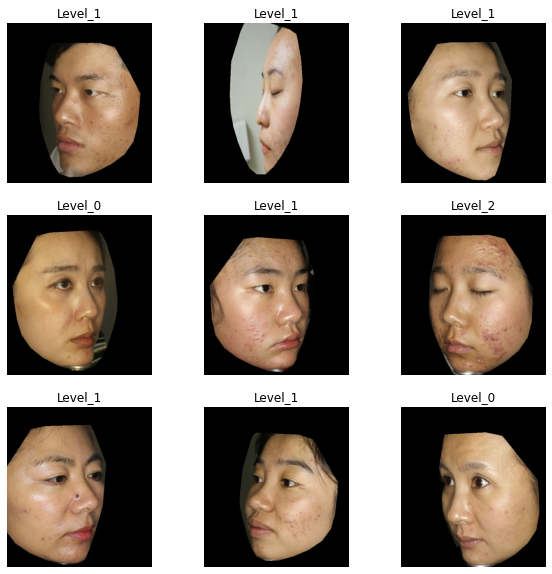

In [75]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Checking Batch Size

In [76]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 555, 500, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [77]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [79]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE_l, IMAGE_SIZE_h),
  layers.experimental.preprocessing.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [80]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0,255),
    
])


#### Checking what is the expected dimension order for channel

In [81]:
input_shape = (IMAGE_SIZE_l, IMAGE_SIZE_h, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE_l, IMAGE_SIZE_h, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE_l, IMAGE_SIZE_h)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE_l, IMAGE_SIZE_h)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [82]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [83]:
# model = models.Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),   
# ])
# model.build(input_shape=batch_input_shape)

### Model Summary

In [84]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (32, 555, 500, 3)         0         
                                                                 
 sequential_12 (Sequential)  (None, 555, 500, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 553, 498, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 276, 249, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 274, 247, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 137, 123, 64)     0         
 g2D)                                                

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [85]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [86]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/8


25/25 [==============================] - 198s 7s/step - loss: 1.0351 - accuracy: 0.4826 - val_loss: 1.0547 - val_accuracy: 0.3958
Epoch 2/8
25/25 [==============================] - 216s 9s/step - loss: 1.0047 - accuracy: 0.4813 - val_loss: 1.0669 - val_accuracy: 0.3958
Epoch 3/8
25/25 [==============================] - 173s 7s/step - loss: 1.0078 - accuracy: 0.4813 - val_loss: 1.0505 - val_accuracy: 0.3958
Epoch 4/8
25/25 [==============================] - 163s 6s/step - loss: 1.0069 - accuracy: 0.4813 - val_loss: 1.0680 - val_accuracy: 0.3958
Epoch 5/8
25/25 [==============================] - 161s 6s/step - loss: 1.0121 - accuracy: 0.4813 - val_loss: 1.0501 - val_accuracy: 0.3958
Epoch 6/8
25/25 [==============================] - 162s 6s/step - loss: 1.0097 - accuracy: 0.4813 - val_loss: 1.0742 - val_accuracy: 0.3958
Epoch 7/8
25/25 [==============================] - 179s 7s/step - loss: 1.0142 - accuracy: 0.4813 - val_loss: 1.1151 - val_accuracy: 0.3958
Epoch 8/8
25/25 [=============

### Testing the Model

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

### Plotting the Accuracy and Loss Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os
model_version = max([int(i) for i in (os.listdir("../../saved_models")+[0])]) + 1
model.save(f"../../saved_models/{model_version}")

### Function for Inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plotting the Inference Data

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")